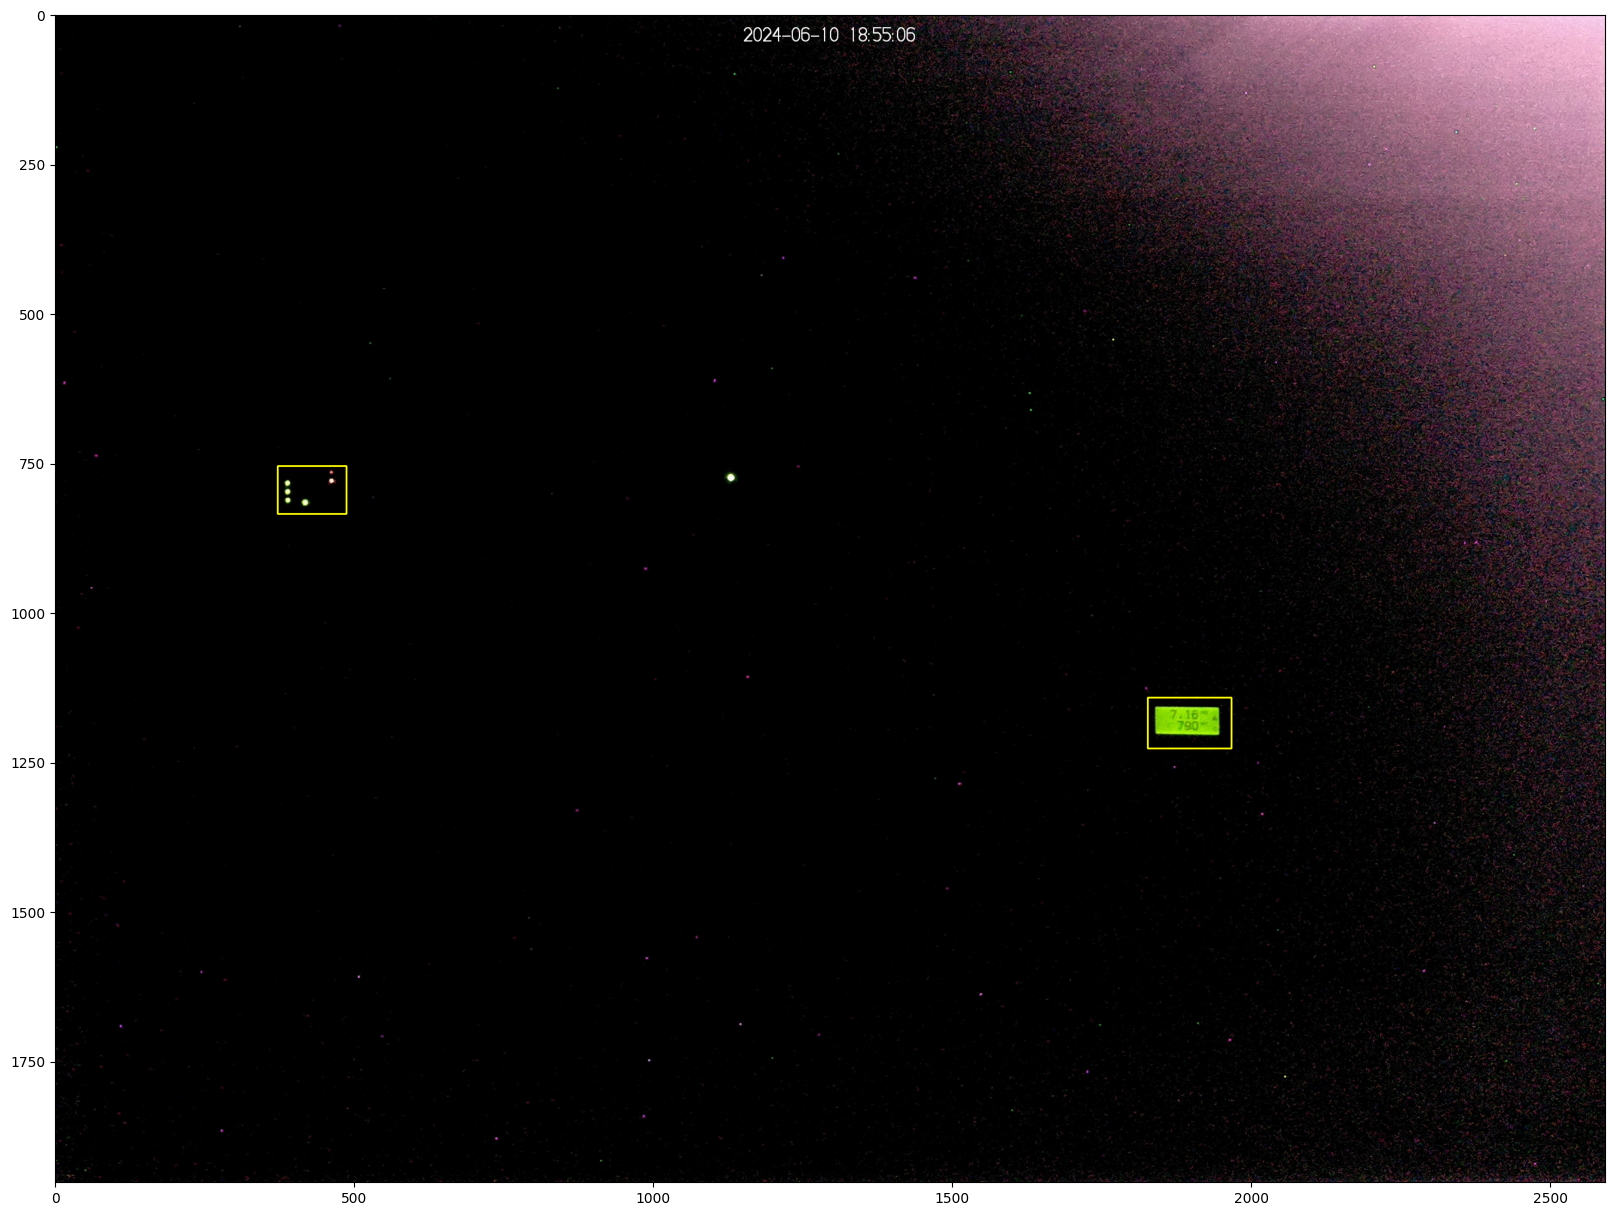

In [2]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import yaml
import cv2 
from matplotlib import pyplot as plt
import numpy as np
import math

def draw_rectangle(image, rectangle_origin, rectangle_size):
    color = (0, 255, 255) 
    thickness = 2

    start_point = (rectangle_origin[0], rectangle_origin[1])
    end_point = (rectangle_origin[0] + rectangle_size[0], rectangle_origin[1] + rectangle_size[1])

    return cv2.rectangle(image, start_point, end_point, color, thickness)

with open('../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

image = cv2.imread("../data/20240610_185506.jpg")
boxes = image.copy()
draw_rectangle(boxes, config["leds"]["rectangle_origin"], config["leds"]["rectangle_size"])
draw_rectangle(boxes, config["lcd"]["rectangle_origin"], config["lcd"]["rectangle_size"])

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(boxes, cv2.COLOR_BGR2RGB))
plt.show()


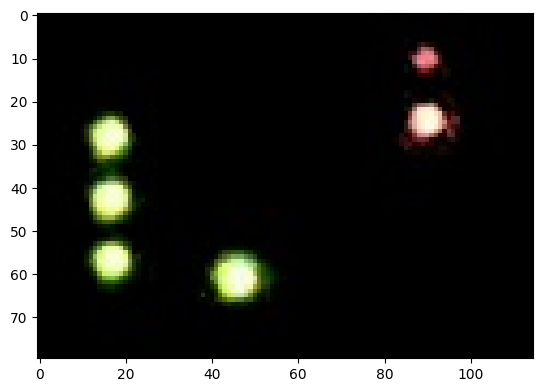

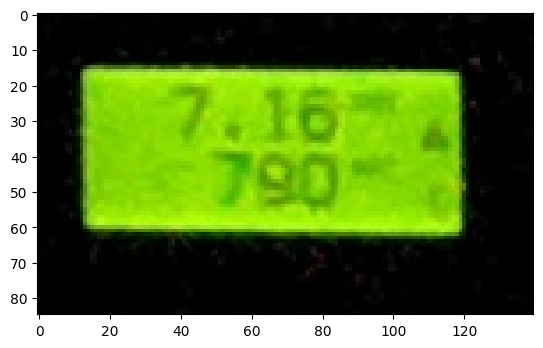

In [3]:
def crop_rectangle(image, rectangle_origin, rectangle_size):

    return image[rectangle_origin[1]:rectangle_origin[1]+rectangle_size[1], rectangle_origin[0]:rectangle_origin[0]+rectangle_size[0]]

leds = crop_rectangle(image, config["leds"]["rectangle_origin"], config["leds"]["rectangle_size"])
lcd = crop_rectangle(image, config["lcd"]["rectangle_origin"], config["lcd"]["rectangle_size"])

#plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(leds, cv2.COLOR_BGR2RGB))
plt.show()

#plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(lcd, cv2.COLOR_BGR2RGB))
plt.show()

[-5  0]


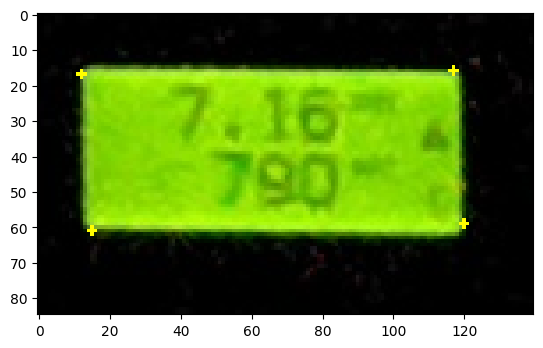

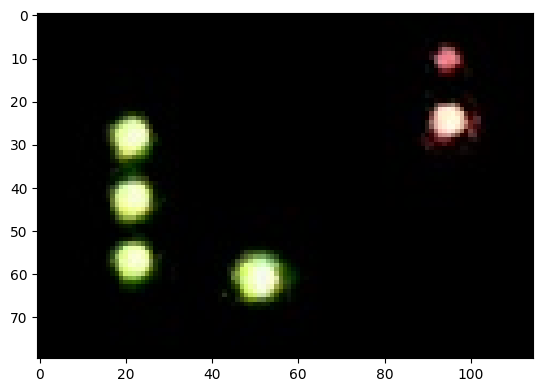

In [4]:
gray = cv2.cvtColor(lcd, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) != 1:
    raise Exception("Multiple contours for LCD found, aborting.")

peri = cv2.arcLength(contours[0], True)
approx = cv2.approxPolyDP(contours[0], 0.04 * peri, True)

lcd_offset = approx[0][0] - (17, 17)
print(lcd_offset)

approx_lcd = lcd.copy()
cv2.drawContours(approx_lcd, approx, -1, (0, 255, 255), 2)

plt.imshow(cv2.cvtColor(approx_lcd, cv2.COLOR_BGR2RGB))
plt.show()

offsetted_origin = tuple(map(sum, zip(config["leds"]["rectangle_origin"], lcd_offset)))

leds = crop_rectangle(image, offsetted_origin, config["leds"]["rectangle_size"])
plt.imshow(cv2.cvtColor(leds, cv2.COLOR_BGR2RGB))
plt.show()


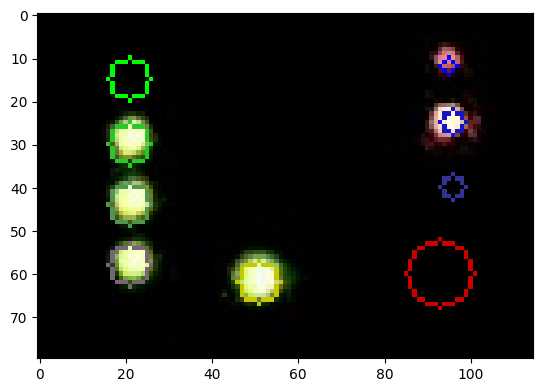

K1: on (Color: (78.6923076923077, 74.15384615384616, 161.46153846153848), Distance: 0.846153846153859)
K2: on (Color: (195.0344827586207, 217.89655172413794, 240.3793103448276), Distance: 0.9740997856431455)
K3: off (Color: (0.0, 0.24137931034482757, 0.3448275862068966), Distance: 179.23103352079468)
S1: off (Color: (0.9259259259259258, 0.4567901234567901, 0.5308641975308641), Distance: 300.37086485677787)
S2: on (Color: (110.34567901234567, 181.2469135802469, 162.39506172839506), Distance: 45.82148119608533)
S3: on (Color: (114.87654320987653, 187.77777777777777, 171.29629629629628), Distance: 38.5474448207664)
S4: on (Color: (107.38271604938271, 180.37037037037035, 157.55555555555554), Distance: 50.34007500946482)
Status: on (Color: (145.37037037037035, 217.0864197530864, 197.8395061728395), Distance: 34.86655379719988)
Black: on (Color: (0.0, 0.0, 0.0), Distance: 0.0)


In [5]:
def annotate_led(img, origin, radius, color):
    leds_visual = img.copy()    
    cv2.circle(leds_visual, (origin[0], origin[1]), radius, color, 1)
    return leds_visual

def get_led_color(img, origin, radius):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask_empty_indicator = np.zeros_like(gray)
    cv2.circle(mask_empty_indicator, (origin[0], origin[1]), radius, 255, -1)

    return cv2.mean(img, mask=mask_empty_indicator)[:3]
    #print("avg_empty_indicator:", avg_empty_indicator)
    #box = np.zeros((10,10,3), np.uint8)
    #cv2.rectangle(box,(0,0),(10,10),(avg_empty_indicator),-1)
    #plt.imshow(cv2.cvtColor(box, cv2.COLOR_BGR2RGB))
    #plt.show()


leds_dict = { 
    "K1": (255, 0, 0), 
    "K2": (200, 20, 20), 
    "K3": (150, 50, 50),
    "S1": (0, 255, 0 ),
    "S2": (40, 200, 40 ),
    "S3": (80, 150, 80 ),
    "S4": (120, 100, 120 ),
    "Status": (0, 200, 200 ),
    "Black": (0, 0, 200)
    }

annotated_leds = leds.copy()
led_colors = {}

for led in leds_dict:
    annotated_leds = annotate_led(annotated_leds, config["leds"][led]["origin"], config["leds"][led]["radius"], leds_dict[led])
    led_colors[led] = get_led_color(leds, config["leds"][led]["origin"], config["leds"][led]["radius"])

plt.imshow(cv2.cvtColor(annotated_leds, cv2.COLOR_BGR2RGB))
plt.show()

for color in led_colors:
    euclidian_distance = math.dist(led_colors[color], tuple(config["leds"][color]["color"]))
    status = "off"
    if euclidian_distance < 100: 
        status = "on"
    print(f"{color}: {status} (Color: {led_colors[color]}, Distance: {euclidian_distance})")


#view_led(leds, config["leds"]["K1"]["origin"], config["leds"]["K1"]["radius"])
#get_led_color(leds, config["leds"]["K1"]["origin"], config["leds"]["K1"]["radius"])

#view_led(leds, config["leds"]["S4"]["origin"], config["leds"]["S4"]["radius"])
#get_led_color(leds, config["leds"]["S4"]["origin"], config["leds"]["S4"]["radius"])
